In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.optimize as opt
from __future__ import division

plt.style.use('ggplot')
%matplotlib inline

In [6]:
TB = pd.read_excel('./Tbill10yr.xls',skiprows=14,convert_float=True,names=['Rate'],index_col=0)
TB.head()

,Rate
DATE,
1953-04-01,2.83
1953-05-01,3.05
1953-06-01,3.11
1953-07-01,2.93
1953-08-01,2.95


In [7]:
TB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 1953-04-01 to 2014-02-01
Data columns (total 1 columns):
Rate    731 non-null float64
dtypes: float64(1)
memory usage: 11.4 KB


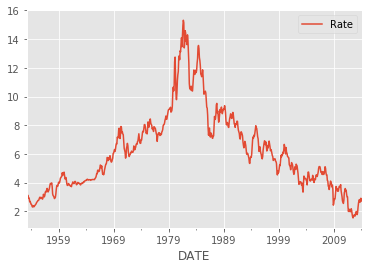

In [8]:
TB.plot()

### OLS

In [62]:
def OLS(Y, X, const=True):
    Y = np.array(Y)
    X = np.c_[np.ones(np.shape(Y)),np.array(X)] if const else np.array(X)
    
    cov = np.dot(np.transpose(X),Y)
    var = np.dot(np.transpose(X),X)

    b = np.dot(np.linalg.inv(var), cov) if np.shape(var) != () else cov / var

    return b if b.shape!=(1,1) else float(b)

def AR_preprocess(TS, ar_lags=1):
    
    df = pd.DataFrame({'y': TS})
    for i in range(1, ar_lags + 1):
        df['x_t' + str(i)] = df.y.shift(i)
        
    df.dropna(inplace=True)
        
    return df

In [99]:
def LogLikelihood(df, c, phi, v):
    
    v = abs(v)
    e = df.y - c - df.iloc[:,1:].dot(np.array(phi))
    T = df.shape[0]
    
    sse = e.T.dot(e)
    
    return float(-T / 2 * (np.log(2 * np.pi * v)) - sse / (2 * v))

### AR(1)

In [107]:
df = AR_preprocess(TB.values.ravel(),1)

y, X = df.y, df.values[:,1:] #sm.add_constant(df.values[:,1:])
beta = OLS(y, X)
beta

array([ 0.02911663,  0.99520032])

In [108]:
ar1_min_object = lambda p: - LogLikelihood(df, p[0], np.array([p[1]]), p[2])
res = opt.minimize(ar1_min_object, [0, 1, 1])

my_theta = res.x
print 'c: %.4f\nphi: %.4f\nsigma^2: %.4f'% tuple(my_theta)
my_theta[-1] ** 0.5

c: 0.0291
phi: 0.9952
sigma^2: 0.0747


0.27337530395171644

In [113]:
arma_model = sm.tsa.ARMA(TB.values, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='c')
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:                     ARMA(1, 0)   Log Likelihood                 -91.453
Method:                       css-mle   S.D. of innovations              0.273
Date:                Sun, 30 Apr 2017   AIC                            188.906
Time:                        22:21:34   BIC                            202.689
Sample:                             0   HQIC                           194.224
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.8613      1.815      2.678      0.008         1.303     8.419
ar.L1.y        0.9954      0.003    321.138      0.000         0.989     1.001
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0046           +0.0000j            1.0046            0.0000
-----------------------------------------------------------------------------
"""

### AR(2)

In [110]:
df = AR_preprocess(TB.values.ravel(), 2)

y, X = df.y, df.values[:,1:] #sm.add_constant(df.values[:,1:])
beta = OLS(y, X)
beta

array([ 0.03729302,  1.30381248, -0.30999947])

In [111]:
ar2_min_object = lambda p: - LogLikelihood(df, p[0], np.array([p[1], p[2]]), p[3])
res = opt.minimize(ar2_min_object, [0, 1, 1, 1])
my_theta = res.x
print 'c: %.4f\nphi_1: %.4f\nphi_2: %.4f\nsigma^2: %.4f'% tuple(my_theta)
my_theta[-1] ** 0.5

c: 0.0373
phi_1: 1.3038
phi_2: -0.3100
sigma^2: 0.0676


0.25998197516366006

In [114]:
arma_model = sm.tsa.ARMA(TB.values, order=(2,0))

ests = arma_model.fit(maxiter=500, trend='c')
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:                     ARMA(2, 0)   Log Likelihood                 -54.699
Method:                       css-mle   S.D. of innovations              0.260
Date:                Sun, 30 Apr 2017   AIC                            117.397
Time:                        22:21:41   BIC                            135.775
Sample:                             0   HQIC                           124.487
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2881      1.431      3.694      0.000         2.483     8.094
ar.L1.y        1.3035      0.035     37.093      0.000         1.235     1.372
ar.L2.y       -0.3095      0.035     -8.796      0.000        -0.378    -0.241
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0088           +0.0000j            1.0088            0.0000
AR.2            3.2028           +0.0000j            3.2028            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:

def info_matrix(y, theta, e, f=LogLikelihood):
    
    L = lambda t: f(y, t[0,0], t[0,1], t[0,2])
    n = len(theta)
    H = np.zeros((n, n))
    theta = theta.reshape(1, n)
    
    for i in range(n):
        for j in range(n):
            if i==j:
                t_p = theta + np.eye(1, n, i) * e
                t_m = theta - np.eye(1, n, i) * e
                H[i, j] = (L(t_p) + L(t_m) - 2*L(theta)) / (e*e)
            else:
                t_i = theta + np.eye(1, n, i) * e
                t_j = theta + np.eye(1, n, j) * e
                t_ij = theta + (np.eye(1, n, i) + np.eye(1, n, j)) * e
                H[i, j] = (L(t_ij) - L(t_i) - L(t_j) + L(theta)) / (e*e)
    
    return -H / len(y)

I = info_matrix(y_jc, my_theta, 0.001)
print I